In [ ]:
%pip install scikit-learn seaborn matplotlib

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Step 1: Load the Dataset
df = pd.read_csv('trees.csv')

/var/folders/7q/gj7yd_s57z9bgskyy_d1112c0000gn/T/ipykernel_8195/3932239858.py:2: DtypeWarning: Columns (7,8,9,11,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('trees.csv')


In [4]:
# Step 2: Initial Data Exploration
print("Initial data overview:")
print(df.head())  # Display the first few rows to understand the structure
print(df.info())  # Get the basic information on data types and missing values

Initial data overview:
   objectid               borough                             maintainer  \
0         1  Kingston upon Thames  Royal Borough of Kingston upon Thames   
1         2  Kingston upon Thames  Royal Borough of Kingston upon Thames   
2         3  Kingston upon Thames  Royal Borough of Kingston upon Thames   
3         4  Kingston upon Thames  Royal Borough of Kingston upon Thames   
4         5  Kingston upon Thames  Royal Borough of Kingston upon Thames   

  gla_tree_name tree_name     taxon_name common_name  age  \
0         Other       NaN  Abies grandis   Grand fir  NaN   
1         Other       NaN  Abies grandis   Grand fir  NaN   
2         Other       NaN  Abies grandis   Grand fir  NaN   
3         Other       NaN  Abies grandis   Grand fir  NaN   
4         Other       NaN  Abies grandis   Grand fir  NaN   

              age_group   height_m  spread_m canopy_spread_group  \
0  Early mature (16-30)  10 to 15m       NaN           00 to 05m   
1  Early mature (

In [5]:
# Step 3A: Convert relevant columns to numeric
# Columns like 'height_m', 'spread_m', 'diameter_at_breast_height_cm' might need conversion to numeric

# Convert columns to numeric, coercing errors to NaN for any non-convertible values
df['height_m'] = pd.to_numeric(df['height_m'], errors='coerce')
df['spread_m'] = pd.to_numeric(df['spread_m'], errors='coerce')
df['diameter_at_breast_height_cm'] = pd.to_numeric(df['diameter_at_breast_height_cm'], errors='coerce')

# Step 3B: Handling Missing Data
# Checking missing values in the dataset
print("\nMissing data in the dataset:")
print(df.isnull().sum())

# We can see there are many missing values in columns like 'tree_name', 'height_m', etc.
# Let's clean the dataset by dropping irrelevant columns and rows with missing target 'condition'


Missing data in the dataset:
objectid                             0
borough                              0
maintainer                           0
gla_tree_name                        0
tree_name                         1234
taxon_name                       51043
common_name                     134919
age                             605989
age_group                       587814
height_m                        732107
spread_m                        716742
canopy_spread_group             798975
diameter_at_breast_height_cm    608998
dbh_group                       798975
longitude                            0
latitude                             0
condition                       798975
load_date                            0
updated                              0
dtype: int64


In [6]:
# Dropping rows where 'condition' is missing since this is our target variable
df_cleaned = df.dropna(subset=['condition'])

# Dropping irrelevant or completely missing columns such as 'height_m', 'spread_m', 'age', and 'tree_name'
df_cleaned = df_cleaned.drop(columns=['height_m', 'spread_m', 'age', 'tree_name'])

In [7]:
# Step 4: Data Cleaning - Check remaining missing values
print("\nRemaining missing data after initial cleaning:")
print(df_cleaned.isnull().sum())


Remaining missing data after initial cleaning:
objectid                            0
borough                             0
maintainer                          0
gla_tree_name                       0
taxon_name                          0
common_name                         0
age_group                           0
canopy_spread_group                 0
diameter_at_breast_height_cm    18175
dbh_group                           0
longitude                           0
latitude                            0
condition                           0
load_date                           0
updated                             0
dtype: int64


/var/folders/7q/gj7yd_s57z9bgskyy_d1112c0000gn/T/ipykernel_8195/4082815711.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='condition', data=df_cleaned, palette='Set2')


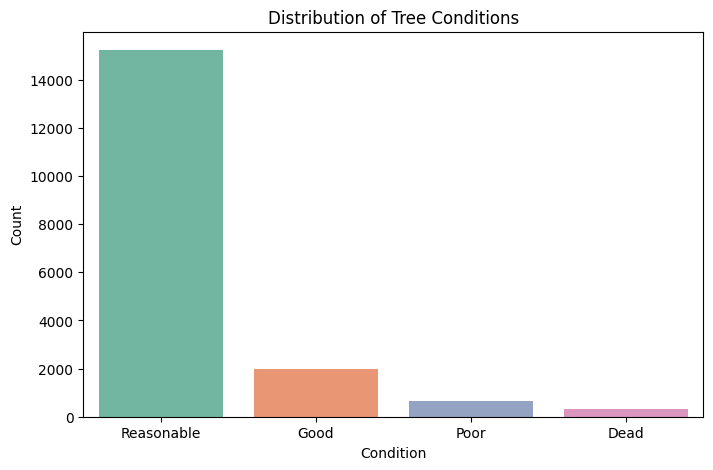

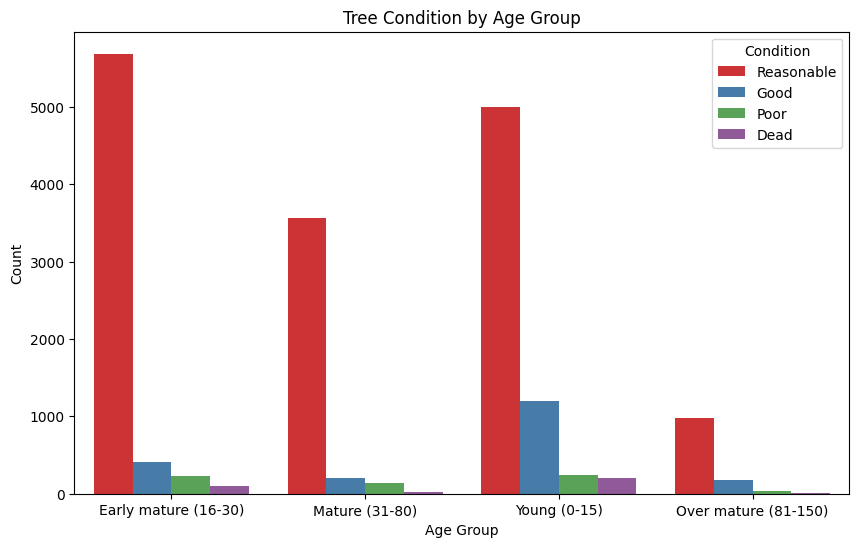

In [8]:
# Step 5: Exploratory Data Analysis (EDA)
# Visualizing the distribution of the 'condition' variable
plt.figure(figsize=(8, 5))
sns.countplot(x='condition', data=df_cleaned, palette='Set2')
plt.title('Distribution of Tree Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

# Visualizing the tree condition by age group
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='condition', data=df_cleaned, palette='Set1')
plt.title('Tree Condition by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Condition')
plt.show()

In [9]:
# Step 6: Encoding Categorical Variables
# We will use LabelEncoder for transforming categorical columns into numeric form
label_encoders = {}
categorical_columns = ['borough', 'gla_tree_name', 'taxon_name', 'common_name', 'age_group', 'canopy_spread_group', 'dbh_group']

for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# Encoding the target variable 'condition'
le_condition = LabelEncoder()
df_cleaned['condition'] = le_condition.fit_transform(df_cleaned['condition'])

In [10]:
# Step 7: Define Features and Target Variable
X = df_cleaned.drop(columns=['condition', 'maintainer', 'load_date', 'updated'])
y = df_cleaned['condition']

In [11]:
# Step 8: Data Pipeline - Automated Data Preprocessing and Modeling
# Define the numerical and categorical columns
numerical_columns = ['longitude', 'latitude']

# Preprocessor to handle categorical encoding and missing value imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),  # One-hot encode categorical variables
        ('num', SimpleImputer(strategy='median'), numerical_columns)  # Impute missing values in numerical columns
    ]
)

In [12]:
# Step 9: Building the Pipeline
# The pipeline will handle both preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))  # Model training with class balancing
])

In [13]:
# Step 10: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 11: Train the Model
pipeline.fit(X_train, y_train)

# Step 12: Model Evaluation
y_pred = pipeline.predict(X_test)

# Generate a classification report to evaluate model performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_condition.classes_))


Classification Report:
              precision    recall  f1-score   support

        Dead       0.38      0.19      0.25        64
        Good       0.74      0.62      0.68       376
        Poor       0.30      0.16      0.21       129
  Reasonable       0.91      0.96      0.94      3066

    accuracy                           0.88      3635
   macro avg       0.58      0.48      0.52      3635
weighted avg       0.86      0.88      0.87      3635



ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11,) and arg 1 with shape (503,).

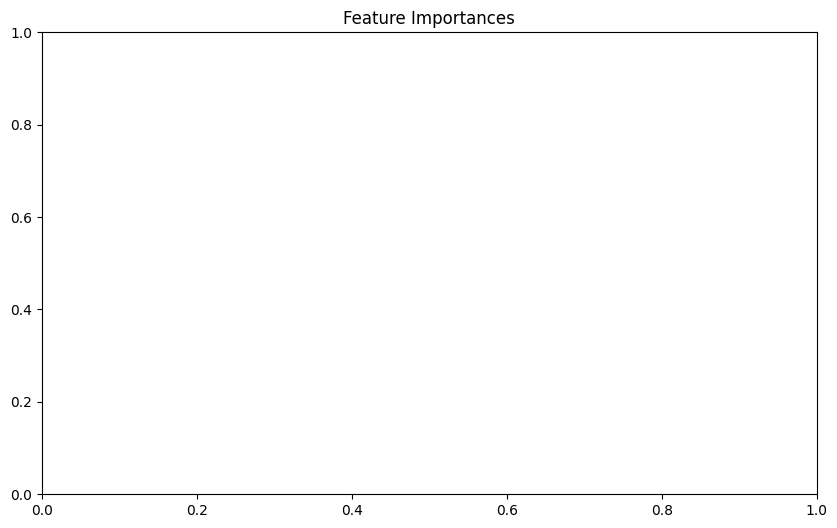

In [14]:
# Step 13: Additional Visualizations (Optional)
# If needed, we can add more visualizations or insights based on the features and predictions

# Example: Visualizing feature importance (if needed)
# This will help understand which features contributed most to the model
rf_model = pipeline.named_steps['classifier']  # Access the Random Forest model
importances = rf_model.feature_importances_
features = X_train.columns
indices = importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.show()